# Visualization of cancer in SHARE's 8th wave

In [78]:
import os
print(os.getcwd())

/Users/josephbarbier/Desktop/BID.com/projects/share


In [79]:
import pandas as pd

br = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_br.dta')
dn = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_dn.dta')
ph = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_ph.dta')

merged_dataframe = pd.merge(br, dn, on = 'mergeid')
merged_dataframe = pd.merge(merged_dataframe, ph, on = 'mergeid')
df = merged_dataframe[['dn014_', 'dn042_',
                       'br002_', 'br015_',
                       'ph003_', 'ph084_',
                       'dn003_', 'ph006d10']]

df.rename(columns={
    'dn014_': 'MaritalStatus',
    'dn042_': 'Gender',
    'dn003_': 'YearOfBirth',
    'br002_': 'Smoking',
    'br015_': 'SportFrequency',
    'ph003_': 'HealthSelfPerception',
    'ph084_': 'Pain',
    'ph006d10': 'Cancer',
    },
    inplace=True)

values_to_replace = ["Don't know", "Refusal",
                     "Implausible value/suspected wrong", 
                     "Not codable", "Not answered",
                     "Not yet coded", "Not applicable"]
df.replace(values_to_replace, float('NaN'), inplace=True)

column_types = {
    'YearOfBirth': 'float',
    'MaritalStatus': 'category',
    'Gender': 'category',
    'Smoking': 'category',
    'SportFrequency': 'category',
    'HealthSelfPerception': 'category',
    'Pain': 'category',
    'Cancer': 'category',
}
df = df.astype(column_types)

df['Age'] = 2021 - df['YearOfBirth']
df.drop(['YearOfBirth'], axis=1, inplace=True)
categorical_columns = df.select_dtypes(include=['category']).columns
for col in categorical_columns:
    df[col] = df[col].cat.add_categories('Unknown').fillna('Unknown')

df.to_csv('../../data/br_dn_ph_wave8.csv', index=False)

/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_8229/3341819974.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_8229/3341819974.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(values_to_replace, float('NaN'), inplace=True)


In [80]:
df = pd.read_csv('../../data/br_dn_ph_wave8.csv')

# drop rows with unknown cancer status
df = df[df.Cancer != 'Unknown']
df.Cancer.value_counts()/len(df)*100

Cancer
Not selected    94.670759
Selected         5.329241
Name: count, dtype: float64

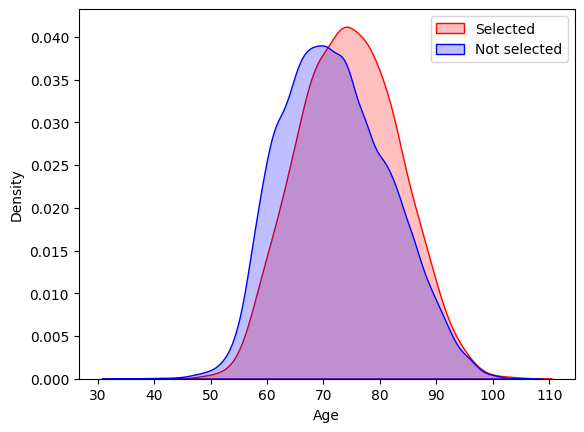

TtestResult(statistic=12.573947193858416, pvalue=3.363094746411365e-36, df=46590.0)

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.kdeplot(df.loc[df['Cancer']=='Selected', 'Age'], fill=True, color="r")
fig = sns.kdeplot(df.loc[df['Cancer']=='Not selected', 'Age'], fill=True, color="b")
plt.legend(['Selected', 'Not selected'])
plt.show()

# print t test for age
from scipy import stats
stats.ttest_ind(df.loc[df['Cancer']=='Selected', 'Age'],
                df.loc[df['Cancer']=='Not selected', 'Age'])


In [82]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def split_fit_predict(X, y, model=LogisticRegression(max_iter=1000), random_state=0, verbose=False):
    
    if verbose:
        print("Model:", type(model).__name__)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    # train model
    model.fit(X_train, y_train)
    
    # prediction
    preds = model.predict_proba(X_test)
    preds = preds[:,1]
    threshold = 0.5
    preds = (preds > threshold).astype(int)
    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, preds)
    rec = recall_score(y_test, preds)
    pre = precision_score(y_test, preds)

    if verbose:
        print(f"Accuracy: {(acc*100):.2f}%")
        print(f"AUC: {(roc):.4f}")
        print(f"Recall: {(rec):.4f}")
        print(f"Precision: {(pre):.4f}")
        print()
    
    # output
    return acc, roc, rec, pre

/Users/josephbarbier/Desktop/BID.com/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


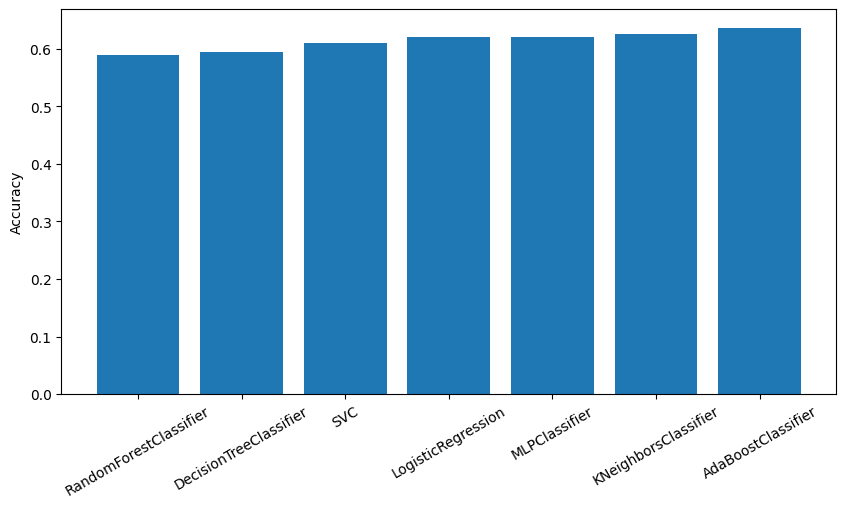

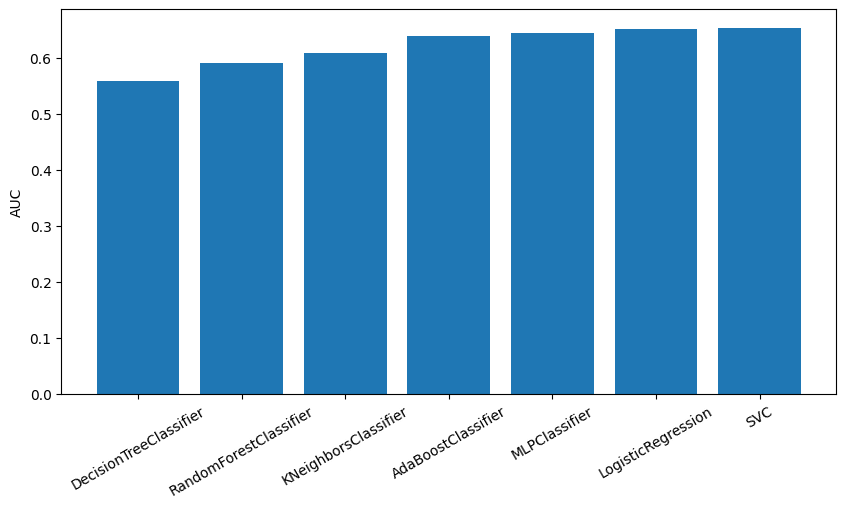

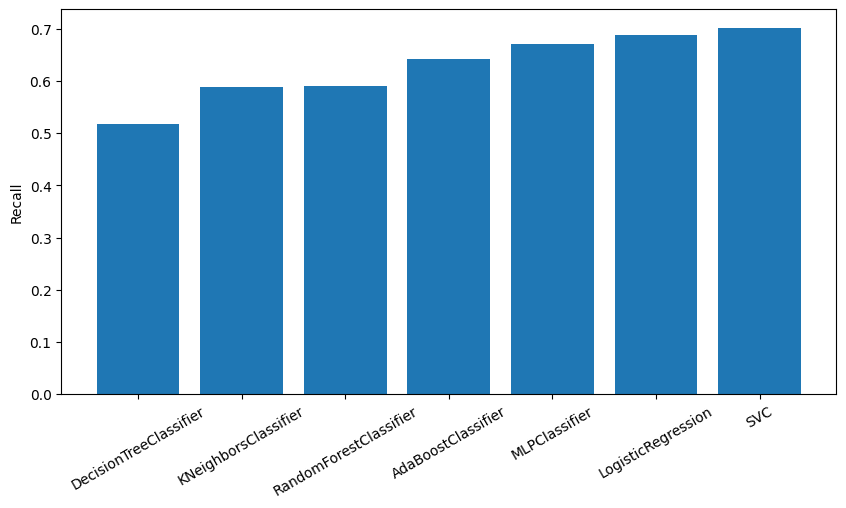

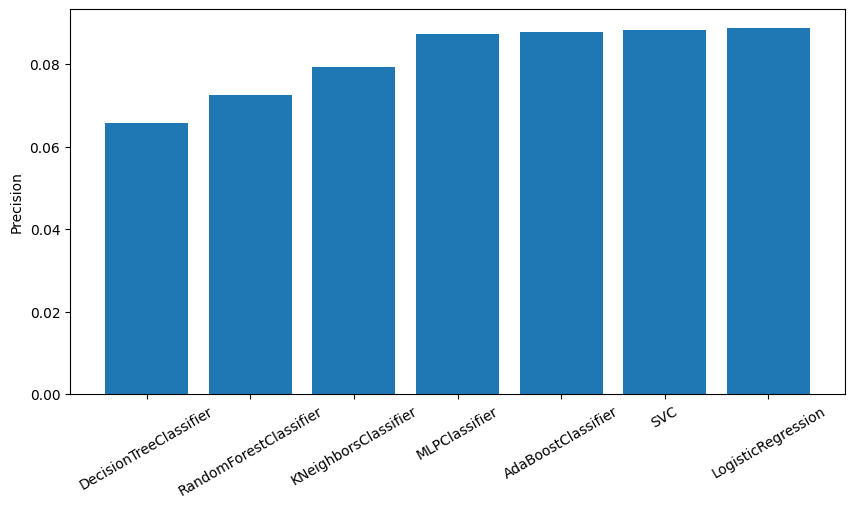

In [85]:
df = pd.read_csv('../../data/br_dn_ph_wave8.csv')
df = df[df.Cancer != 'Unknown']
df['Cancer'] = df['Cancer'].replace({'Selected': 1, 'Not selected': 0})
target = 'Cancer'
y = df[target]
df.drop([target], axis=1, inplace=True)

# encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
df_categorical = pd.get_dummies(df[categorical_cols],
                                columns = categorical_cols,
                                drop_first = True)

# scale numerical columns
numeric_cols = df.select_dtypes(include=['float']).columns
df_numerical = df[numeric_cols]
df_numerical = (df_numerical-df_numerical.mean()) / df_numerical.std()

# merge dfs
X = pd.concat([df_categorical, df_numerical], axis=1)
X = X.astype(float)

# fit model
accs = []
rocs = []
recs = []
pres = []
labels = []
models = [LogisticRegression(max_iter=1000),
            RandomForestClassifier(),
            AdaBoostClassifier(),
            DecisionTreeClassifier(),
            SVC(probability=True),
            KNeighborsClassifier(),
            MLPClassifier()]
for model in models:
    labels.append(type(model).__name__)
    acc, roc, rec, pre = split_fit_predict(X, y, model=model, random_state=0)
    accs.append(acc)
    rocs.append(roc)
    recs.append(rec)
    pres.append(pre)

# plot results
def compare_models(metric, metric_name, labels=labels):
    
    #sort by metric
    metric, labels = zip(*sorted(zip(metric, labels)))
    
    #plot
    plt.figure(figsize=(10,5))
    plt.bar(labels, metric)
    plt.ylabel(metric_name)
    plt.xticks(rotation=30)
    plt.show()

compare_models(accs, 'Accuracy')
compare_models(rocs, 'AUC')
compare_models(recs, 'Recall')
compare_models(pres, 'Precision')
